# Posts that beat the median
We're going to process our data a bit more so that we can build some models that will try to answer the following question:

> Q: For a given post, does this post have more than the median score or not?

The this end we'll transform our text data into numerical data that we can work with.

In [1]:
import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt

from itertools import product

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import HashingVectorizer

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier



In [2]:
df = pd.read_csv('../data/csv/all_processed.csv')

In [3]:
text_feats = ['title', 'selftext']
num_and_bool_feats = [col for col in df.columns if col not in text_feats + ['subreddit']]
df[num_and_bool_feats] = df[num_and_bool_feats].copy().astype(float)

df.head()

,title,score,over_18,subreddit,created_utc,is_self,higher_than_median,num_comments_log1p,title_len_log1p
0,Dave Bautista has achieved full Drax.,22715.0,0.0,funny,1.527526e+09,0.0,1.0,5.802118,3.637586
1,Not even safe in Super Mario 64...,36365.0,0.0,gaming,1.527525e+09,0.0,1.0,6.135565,3.555348
2,rapid-fire cigar box juggling (sort of looks l...,56601.0,0.0,gifs,1.527522e+09,0.0,1.0,6.461468,4.174387
3,Very true,43332.0,0.0,pics,1.527526e+09,0.0,1.0,7.870166,2.302585
4,Couple with Down's syndrome celebrate 22 years...,27582.0,0.0,aww,1.527525e+09,0.0,1.0,6.431331,4.094345


The only remaining preprocessing is in tokenizing the titles. We can just do this in a pipeline without too much difficulty after we split everything into training and testing sets, so let's do that now. 

In [4]:
X = df.drop(['higher_than_median', 'score'],1)
y = df['higher_than_median']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=41)

## Encoding Text as Numerical Features

Some explanation for NLP and feature extraction for text.


As a warm up we will encode the subreddit name as a collection of dummy variables. 

In [5]:
X_dum_train = pd.get_dummies(X_train['subreddit'])
X_dum_test = pd.get_dummies(X_test['subreddit'])

for col in X_dum_test:
    if col not in X_dum_train.columns:
        X_dum_test.drop(col, 1, inplace=True)

for col in X_dum_train:
    if col not in X_dum_test.columns:
        X_dum_test[col] = pd.Series([0 for _ in X_dum_test.index], index=X_dum_test.index)

X_train = X_train.join(X_dum_train)
X_train.drop('subreddit', 1, inplace=True)

X_test = X_test.join(X_dum_test)
X_test.drop('subreddit', 1, inplace=True)


I'm going to want to use a tf-idf tokenizer on the `title` feature, but to do this with a pipeline object from SKLearn, we can define a custom transformer that will only affect the `title`. This is not built in complete generality, so I make no promise that it will work without modification to a different data structure (i.e. if you're using different matrix encodings). 

In [6]:
from sklearn.base import TransformerMixin, BaseEstimator

class Hvec_Col(TransformerMixin, BaseEstimator):
    def __init__(self, cols=[]):
        self.cols = cols
        self.vects = {col:HashingVectorizer() for col in cols}
        
    def transform(self, X, *_):
        X = X.copy()
        transformed = []
        for col in self.cols:
            tmp = self.vects[col].transform(X.loc[:,col])
            transformed.append(tmp)
            X.drop(col, 1, inplace=True)
            
        X = scipy.sparse.csr_matrix(X.values)
        transformed.append(X)
        X = scipy.sparse.hstack(transformed)
        return X
        
    def fit(self, X, *_):
        for col in self.cols:
            self.vects[col].fit(X.loc[:,col])
        return self

## Logistic Regression regression with $\ell_2$ penalty

In [7]:
pl = [
    ('hvec', Hvec_Col(['title'])),
    ('ss', StandardScaler(with_mean=False)),
    ('logreg', LogisticRegression()),
]

np.random.seed(41)

my_params = {
    'logreg__C':np.random.uniform(0,2,100),
}

pipe = Pipeline(pl)
logreg = GridSearchCV(pipe, param_grid=my_params, return_train_score=True)

logreg.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('hvec', Hvec_Col(cols=['title'])), ('ss', StandardScaler(copy=True, with_mean=False, with_std=True)), ('logreg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logreg__C': array([0.50185, 0.09219, ..., 0.11774, 0.66999])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Text(0.5,0,'Inverse Regularization strength C')

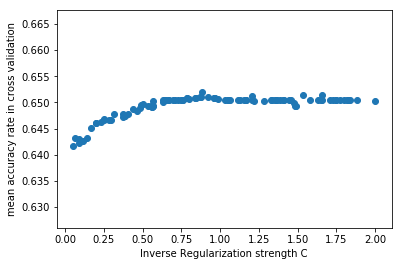

In [8]:
x = []
y = []
for index, score in enumerate(logreg.cv_results_['mean_test_score']):
    C = logreg.cv_results_['params'][index]['logreg__C']
    x.append(C)
    y.append(score)
plt.scatter(x,y)
plt.ylabel('mean accuracy rate in cross validation')
plt.xlabel('Inverse Regularization strength C')

In [9]:
logreg.best_params_

{'logreg__C': 0.8833292081555872}

In [10]:
logreg.score(X_train, y_train), logreg.score(X_test, y_test)

(0.9946793615233828, 0.6388072238555229)

The logistic regression model is very ***overfit***, as evidenced by the gulf between the two accuracy rates above. In the future, we might try to also compare with $\ell_1$ norm regularization.

## K-Nearest Neighbors

In [11]:
pl = [
    ('hvec', Hvec_Col(['title'])),
    ('ss', StandardScaler(with_mean=False)),
    ('knn', KNeighborsClassifier()),
]

np.random.seed(41)

my_params = {
    'knn__n_neighbors':range(4,25),
}

pipe = Pipeline(pl)
knn = GridSearchCV(pipe, param_grid=my_params, return_train_score=True)

knn.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('hvec', Hvec_Col(cols=['title'])), ('ss', StandardScaler(copy=True, with_mean=False, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'knn__n_neighbors': range(4, 25)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [12]:
knn.best_params_

{'knn__n_neighbors': 14}

Text(0.5,0,'number of neighbors')

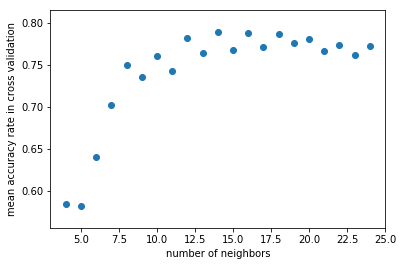

In [13]:
x = []
y = []
for index, score in enumerate(knn.cv_results_['mean_test_score']):
    n_neighbors = knn.cv_results_['params'][index]['knn__n_neighbors']
    x.append(n_neighbors)
    y.append(score)
plt.scatter(x,y)
plt.ylabel('mean accuracy rate in cross validation')
plt.xlabel('number of neighbors')

In [14]:
knn.score(X_train, y_train), knn.score(X_test, y_test)

(0.8410809297115653, 0.7690046199076018)

## Decision Tree

In [20]:
pl = [
    ('hvec', Hvec_Col(['title'])),
    ('ss', StandardScaler(with_mean=False)),
    ('dt', DecisionTreeClassifier()),
]

np.random.seed(41)

my_params = {
    'dt__max_depth':range(2,20),
}

pipe = Pipeline(pl)
dt = GridSearchCV(pipe, param_grid=my_params, return_train_score=True)

dt.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('hvec', Hvec_Col(cols=['title'])), ('ss', StandardScaler(copy=True, with_mean=False, with_std=True)), ('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_im...     min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'dt__max_depth': range(2, 20)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

Text(0.5,0,'max depth of tree')

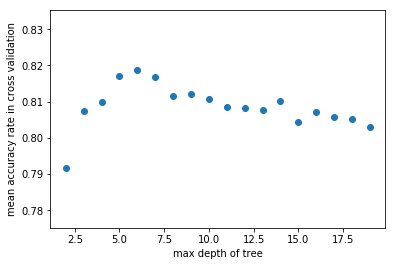

In [21]:
x = []
y = []
for index, score in enumerate(dt.cv_results_['mean_test_score']):
    max_depth = dt.cv_results_['params'][index]['dt__max_depth']
    x.append(max_depth)
    y.append(score)
plt.scatter(x,y)
plt.ylabel('mean accuracy rate in cross validation')
plt.xlabel('max depth of tree')

In [23]:
dt.best_params_

{'dt__max_depth': 6}

In [22]:
dt.score(X_train, y_train), dt.score(X_test, y_test)

(0.8398207784934192, 0.8021839563208736)

## Random Forest

In [20]:
pl = [
    ('tfidf', Tfidf_Col(['title'])),
    ('ss', StandardScaler(with_mean=False)),
    ('rf', RandomForestClassifier()),
]

np.random.seed(41)

my_params = {
    {'rf__n_estimators'}:range(6,14),
}

pipe = Pipeline(pl)
rf = GridSearchCV(pipe, param_grid=my_params, return_train_score=True)

rf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', Tfidf_Col(cols=['title'])), ('ss', StandardScaler(copy=True, with_mean=False, with_std=True)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [21]:
rf.score(X_test, y_test)

0.9878202435951281